CKKS public-key encryption of message ($m$) calculates : 

$(c_0,c_1)=((p_0v+e_0+m),(p_1v+e1))(modQ),$

, where $p_0$, $p_1$ are the public key components, $v$ is a random ring element in $R_Q$ following a uniform distribution, and $e_0$, $e_1$ are random ring elements from a truncated Gaussian distribution.

To fix the encryption, you’ll need to manually modify the random elements mentioned above. Be aware that this is an invasive procedure and carries risks. OpenFHE doesn’t provide any built-in methods for this modification.

CKKS encryption logic can be found [here](https://github.com/openfheorg/openfhe-development/blob/v1.1.2/src/pke/lib/schemerns/rns-pke.cpp#L55).

https://openfhe.discourse.group/t/ckks-controling-prng-in-encryption/999/3

https://openfhe-development.readthedocs.io/en/latest/api/classlbcrypto_1_1DiscreteGaussianGeneratorGeneric.html

https://openfhe.discourse.group/t/ckks-rlwe-regarding-the-value-of-sigma/613

## Gaussian PDF (Probability Density Function)

---

### 📊 What is a PDF?

**PDF = Probability Density Function**

- It describes how **probability is distributed** over the values of a **continuous random variable**.
- **Important**: For continuous variables, we **can’t talk about P(X = x)** (it’s always 0).  
  Instead, we talk about **P(a ≤ X ≤ b) = area under PDF between a and b**.

---

### 🧮 The Gaussian (Normal) PDF Formula

For a Gaussian distribution with:
- **Mean = μ** (center of the bell)
- **Standard deviation = σ** (width of the bell)

The PDF is:

$$
\boxed{f(x) = \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}}
$$

---

### 🔍 Breaking Down the Formula

| Part | What it does |
|------|-------------|
| **\( e^{-\frac{(x - \mu)^2}{2\sigma^2}} \)** | Creates the **bell shape**:<br>• Maximum at **x = μ**<br>• Decreases as you move away from μ<br>• Wider if **σ is large**, narrower if **σ is small** |
| **\( \frac{1}{\sigma \sqrt{2\pi}} \)** | **Normalization constant**:<br>• Ensures total area under curve = 1<br>• If σ increases (wider bell), height decreases to keep area = 1 |

---

### 📈 Key Properties of the Gaussian PDF

1. **Symmetric** around **x = μ**
2. **Peak** at **x = μ**, with height = \( \frac{1}{\sigma \sqrt{2\pi}} \)
3. **Inflection points** at **x = μ ± σ** (where curve changes from concave to convex)
4. **Total area = 1** → represents 100% probability
5. **Never touches zero** — but gets extremely close as |x| → ∞

---

### 🎯 The 68–95–99.7 Rule (Empirical Rule)

For any Gaussian distribution:

| Interval | Probability |
|---------|-------------|
| **μ ± 1σ** | ≈ **68.27%** of data |
| **μ ± 2σ** | ≈ **95.45%** of data |
| **μ ± 3σ** | ≈ **99.73%** of data |

✅ This is why **σ = 3.2** in FHE is safe: noise stays small with very high probability.

---

### 🖼️ Visual Description (Imagine This)

```
        ^
        |     **
f(x)    |    *  *
        |   *    *
        |  *      *
        | *        *
        |*          *
--------+-------------> x
       μ-σ   μ   μ+σ
```

- Tallest point at **μ**
- Curve drops to ~60% of max height at **μ ± σ**
- Almost flat beyond **μ ± 3σ**

---

### ⚠️ Critical: PDF vs. Probability

- **PDF value f(x) is NOT a probability**  
  (it can be > 1! For example, if σ = 0.1, peak height ≈ 4.0)

- **Probability = area under curve**  
  Example:  
  \( P(μ - σ ≤ X ≤ μ + σ) = \int_{μ-σ}^{μ+σ} f(x)  dx ≈ 0.6827 \)

---

### 🔧 Why Gaussian in FHE?

In FHE (RLWE-based schemes):
- **Error terms** are sampled from **discrete Gaussian**
- Why? Because:
  1. **Security**: Hard to distinguish from uniform if noise is Gaussian
  2. **Correctness**: Noise grows predictably (sub-Gaussian tails)
  3. **Optimality**: Gaussian minimizes entropy for a given noise bound

> 💡 Your hardware sampler approximates this continuous PDF with a **discrete PMF** over integers.

---

### 📐 Standard Normal Distribution

When **μ = 0** and **σ = 1**, it’s called the **standard normal**:

\[
\phi(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}
\]

All other Gaussians are just **scaled and shifted** versions of this.

---

### ✅ Summary

> The **Gaussian PDF** is a **bell-shaped curve** that describes how probability is distributed for a continuous random variable.  
> - **Center**: μ  
> - **Width**: σ  
> - **Area under curve = 1**  
> - **Used in FHE for secure, controllable noise**

The standard deviation that we use below is chosen as $\sigma = 8\sqrt{2\pi} \approx 3.2$ based on https://homomorphicencryption.org/wp-content/uploads/2018/11/HomomorphicEncryptionStandardv1.1.pdf

In [130]:
import math
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from collections import Counter

From OpenFHE for benchmark

In [128]:
# Read PRNG outputs from file
start_line = 12          # 1-based
end_line = 12 + 65535    # 65536 values total

with open("gaussian.txt", "r") as file:
    lines = file.readlines()

# Extract selected lines (convert to 0-based indexing)
selected_lines = lines[start_line - 1:end_line]

# for x in range(len(selected_lines)):
#     selected_lines[x] = int(selected_lines[x].strip())
#     print(f"{x}: {selected_lines[x]}")

# Count frequencies
# freq = Counter(selected_lines)
# print("Gaussian Frequencies:")
# for val in sorted(freq):
#     print(f"{val}: {freq[val]}")

Loaded 65536 samples
Min: -15, Max: 14


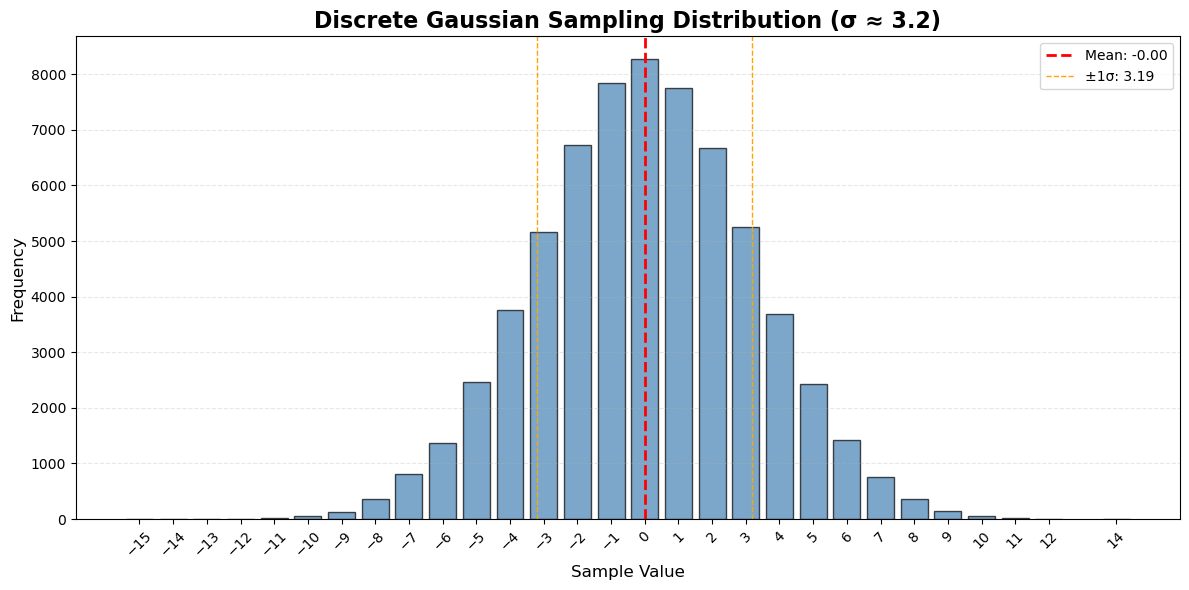

In [133]:
# Convert to integers
samples = []
for line in selected_lines:
    try:
        val = int(line.strip())
        samples.append(val)
    except ValueError:
        continue

# 👇 THIS IS CRITICAL - CREATE freq FROM samples
freq = Counter(samples)

print(f"Loaded {len(samples)} samples")
print(f"Min: {min(samples)}, Max: {max(samples)}")

# Create bar plot
plt.figure(figsize=(12, 6))
values = sorted(freq.keys())  # Now sorts integers correctly!
counts = [freq[val] for val in values]

plt.bar(values, counts, width=0.8, color='steelblue', edgecolor='black', alpha=0.7)

# Styling
plt.title('Discrete Gaussian Sampling Distribution (σ ≈ 3.2)', fontsize=16, fontweight='bold')
plt.xlabel('Sample Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(values, rotation=45)

# Add some statistics to the plot
mean_val = np.mean(samples)
std_val = np.std(samples)
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(mean_val + std_val, color='orange', linestyle='--', linewidth=1, label=f'±1σ: {std_val:.2f}')
plt.axvline(mean_val - std_val, color='orange', linestyle='--', linewidth=1)

plt.legend()
plt.tight_layout()

# Save and show
# plt.savefig('gaussian_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Proposed design

In [41]:
qp = np.array([281474976317441, 140737518764033, 140737470791681, 140737513783297,
        140737471578113, 140737513259009, 140737471971329, 140737509851137,
        140737480359937, 140737509457921, 140737481801729, 140737508671489,
        140737482981377, 140737506705409, 140737483898881, 140737504608257,
        140737484685313, 140737499496449, 140737485864961, 140737493729281,
        140737486520321, 140737490976769, 140737487306753, 140737488486401,
        281474975662081, 281474974482433, 281474966880257, 281474962554881,
        281474960326657, 281474957180929, 281474955476993, 281474952462337],
       dtype=object)

In [2]:
# ------------------------------
# Discrete Gaussian via CDT
# ------------------------------
@dataclass
class GaussianCDTTable:
    sigma: float
    tail_sigma: float = 10.0  # truncate at ~10*sigma by default

    def __post_init__(self):
        # Build nonnegative-side probabilities P[X = k] ∝ exp(-pi * k^2 / sigma^2)
        # for k >= 0 (we will add sign later; note that k=0 is unique).
        tmax = max(20, int(math.ceil(self.tail_sigma * self.sigma)))
        ks = np.arange(0, tmax + 1, dtype=np.int64)
        rho = np.exp(-math.pi * (ks.astype(np.float64) ** 2) / (self.sigma ** 2))
        # Normalize for nonnegative side (we sample k >= 0; sign handled after)
        Z = rho.sum()
        p = rho / Z  # P_nonneg[k]
        cdf = np.cumsum(p)
        cdf[-1] = 1.0  # guard against float drift
        self.ks = ks
        self.cdf = cdf

    def sample_nonneg(self, n: int, rng: np.random.Generator) -> np.ndarray:
        u = rng.random(n)
        idx = np.searchsorted(self.cdf, u, side="left")
        return self.ks[idx]

def sample_discrete_gaussian_cdt(n: int, sigma: float, tail_sigma: float = 10.0,
                                 rng: np.random.Generator | None = None) -> np.ndarray:
    """
    Two-sided discrete Gaussian via CDT on the nonnegative side + random sign.
    Returns integer samples with stddev approximately sigma (tail truncated).
    """
    if rng is None:
        rng = np.random.default_rng()
    table = GaussianCDTTable(sigma=sigma, tail_sigma=tail_sigma)
    k = table.sample_nonneg(n, rng)
    # random sign for k>0 (k=0 stays 0)
    s = rng.integers(0, 2, size=n, dtype=np.int8) * 2 - 1  # in {-1, +1}
    x = (k * s).astype(np.int64)
    x[k == 0] = 0
    return x

CDT Table ks: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
CDT Table cdf: [0.47619048 0.8265717  0.96615106 0.99625489 0.99977003 0.99999225
 0.99999986 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
Target sigma: 3.2
Empirical mean: -0.0033
Empirical std:  1.1152


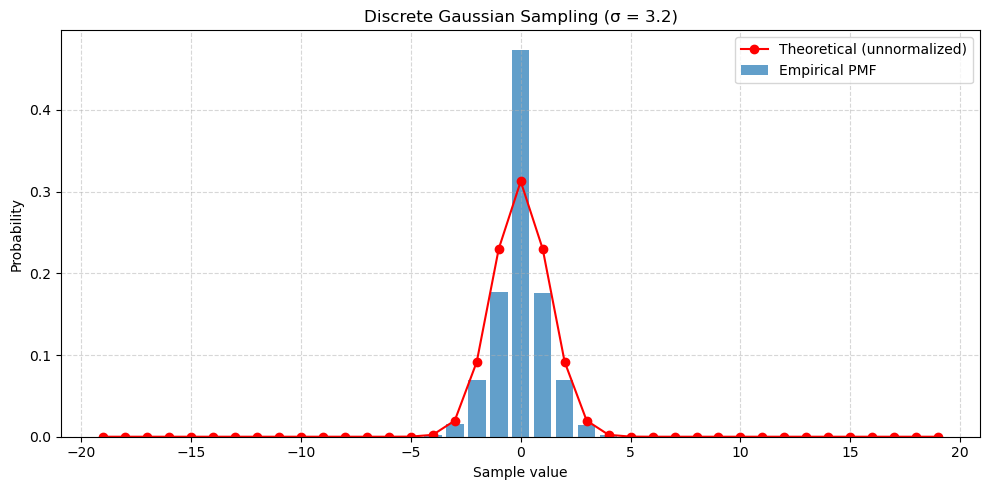


First 20 samples: [ 1  0  2  1  0  3 -1  1  0  0  0  2  1 -1  0  0  1  0 -2  1]


In [1]:
import math
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt

# ------------------------------
# Discrete Gaussian via CDT
# ------------------------------
@dataclass
class GaussianCDTTable:
    sigma: float
    tail_sigma: float = 10.0  # truncate at ~10*sigma by default

    def __post_init__(self):
        # Build nonnegative-side probabilities P[X = k] ∝ exp(-pi * k^2 / sigma^2)
        tmax = max(20, int(math.ceil(self.tail_sigma * self.sigma)))
        ks = np.arange(0, tmax + 1, dtype=np.int64)
        rho = np.exp(-math.pi * (ks.astype(np.float64) ** 2) / (self.sigma ** 2))
        Z = rho.sum()
        p = rho / Z
        cdf = np.cumsum(p)
        cdf[-1] = 1.0  # guard against float drift
        self.ks = ks
        self.cdf = cdf

    def sample_nonneg(self, n: int, rng: np.random.Generator) -> np.ndarray:
        u = rng.random(n)
        idx = np.searchsorted(self.cdf, u, side="left")
        return self.ks[idx]


def sample_discrete_gaussian_cdt(
    n: int,
    sigma: float,
    tail_sigma: float = 10.0,
    rng: np.random.Generator | None = None
) -> np.ndarray:
    """
    Two-sided discrete Gaussian via CDT on the nonnegative side + random sign.
    Returns integer samples with stddev approximately sigma (tail truncated).
    """
    if rng is None:
        rng = np.random.default_rng()
    table = GaussianCDTTable(sigma=sigma, tail_sigma=tail_sigma)
    print("CDT Table ks:", table.ks)
    print("CDT Table cdf:", table.cdf)
    k = table.sample_nonneg(n, rng)
    # random sign for k > 0; k=0 stays 0
    signs = rng.integers(0, 2, size=n, dtype=np.int8) * 2 - 1  # {-1, +1}
    x = k * signs
    x[k == 0] = 0  # ensure zero stays zero (redundant but safe)
    return x.astype(np.int64)


# ------------------------------
# Example Usage
# ------------------------------
if __name__ == "__main__":
    # Parameters
    sigma = 3.2          # Standard deviation (common in RLWE: e.g., 3.2)
    n_samples = 100_000  # Number of samples to generate
    seed = 42            # For reproducibility

    # Create RNG
    rng = np.random.default_rng(seed)

    # Generate samples
    samples = sample_discrete_gaussian_cdt(n=n_samples, sigma=sigma, rng=rng)

    # Basic statistics
    empirical_std = np.std(samples)
    empirical_mean = np.mean(samples)
    print(f"Target sigma: {sigma}")
    print(f"Empirical mean: {empirical_mean:.4f}")
    print(f"Empirical std:  {empirical_std:.4f}")

    # Plot histogram
    plt.figure(figsize=(10, 5))
    values, counts = np.unique(samples, return_counts=True)
    plt.bar(values, counts / n_samples, width=0.8, alpha=0.7, label="Empirical PMF")
    
    # Overlay theoretical probabilities (for comparison)
    k_vals = np.arange(-int(6*sigma), int(6*sigma)+1)
    theoretical_p = np.exp(-np.pi * (k_vals ** 2) / (sigma ** 2))
    theoretical_p /= theoretical_p.sum()  # normalize
    plt.plot(k_vals, theoretical_p, 'ro-', label="Theoretical (unnormalized)")

    plt.title(f"Discrete Gaussian Sampling (σ = {sigma})")
    plt.xlabel("Sample value")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Example: small batch of actual samples
    print("\nFirst 20 samples:", samples[:20])

In [2]:
import numpy as np
from math import ceil
# ---------- build integer CDT (nonnegative) ----------
def build_cdt_int(sigma, tail_sigma=10.0, lam=64):
    tmax = max(20, int(ceil(tail_sigma*sigma)))
    k = np.arange(0, tmax+1, dtype=np.int64)
    rho = np.exp(-np.pi * (k**2) / (sigma**2))
    p = rho / rho.sum()                  # normalize NONNEG side
    cdf = np.minimum(np.cumsum(p), 1.0)
    T = np.minimum((cdf * (1<<lam)).astype(np.uint64), (1<<lam)-1)  # integer thresholds
    return k, T

# ---------- fixed-iteration CDT binary search ----------
def cdt_sample_idx(T, r):
    # search smallest idx with r < T[idx]
    N = len(T)
    jmp = 1 << (N.bit_length()-1)   # >= N/2
    cur = 0
    while jmp > 0:
        nxt = cur + jmp
        if nxt < N and r >= T[nxt]:
            cur = nxt
        jmp >>= 1
    return cur  # nonnegative index

# ---------- generate samples (±k) ----------
def sample_gauss(n, T, lam=64, rng=None):
    rng = rng or np.random.default_rng(123)
    r = rng.integers(0, 1<<lam, size=n, dtype=np.uint64)
    idx = np.array([cdt_sample_idx(T, ri) for ri in r], dtype=np.int64)
    b = rng.integers(0, 2, size=n, dtype=np.int8)  # sign bit
    x = (1 - 2*b) * idx
    x[idx==0] = 0
    return x, r, b, idx

# ---------- stats + quick tests ----------
if __name__ == "__main__":
    sigma = 3.2
    k, T = build_cdt_int(sigma, tail_sigma=10.0, lam=64)
    x, r, b, idx = sample_gauss(200_000, T, lam=64)

    print(f"mean≈0? {x.mean():.4f},  std≈σ? {x.std():.4f} (target σ={sigma})")
    # 3σ rule sanity:
    frac_out_3sigma = (np.abs(x) > 3*sigma).mean()
    print(f"P(|x|>3σ) ≈ {frac_out_3sigma:.4f}  (expected ~0.003–0.01 depending on discretization)")

    # ---- write goldens for RTL testbench ----
    # CDF table
    np.savetxt("cdt_table.hex", T, fmt="%016x")  # 64-bit hex per line
    # stimuli r & b, expected index and signed x
    np.savetxt("stim_r.hex", r, fmt="%016x")
    np.savetxt("stim_b.hex", b, fmt="%01x")
    np.savetxt("gold_idx.hex", idx, fmt="%08x")
    # If your RTL outputs mod-q values instead of ±k:
    #   x_mod = np.where(b==0, idx, (q - idx) % q).astype(np.uint64)
    # else (±k integer):
    x_signed = x.astype(np.int64)  # two's complement for 64b compare
    np.savetxt("gold_x.hex", x_signed, fmt="%016x")


mean≈0? 0.0027,  std≈σ? 0.5449 (target σ=3.2)
P(|x|>3σ) ≈ 0.0000  (expected ~0.003–0.01 depending on discretization)


In [2]:
import math
import bisect

class PeikertGaussianSampler:
    def __init__(self, sigma=3.2, center=0):
        self.sigma = sigma
        self.center = center
        self.B = int(math.ceil(6 * sigma))
        self._precompute_cdf()
    
    def _precompute_cdf(self):
        self.x_vals = list(range(self.center - self.B, self.center + self.B + 1))
        self.probs = []
        for x in self.x_vals:
            dx = x - self.center
            prob = math.exp(- (dx * dx) / (2 * self.sigma * self.sigma))
            self.probs.append(prob)
        
        self.cdf = []
        cumsum = 0.0
        for p in self.probs:
            cumsum += p
            self.cdf.append(cumsum)
        self.total_mass = self.cdf[-1]
    
    def sample_from_prng32(self, prng32_value):
        """
        Sample using a 32-bit PRNG output (0 to 2^32-1)
        
        Args:
            prng32_value (int): 32-bit unsigned integer from PRNG
        
        Returns:
            int: Sampled Gaussian value
        """
        if not (0 <= prng32_value <= 0xFFFFFFFF):
            raise ValueError("Input must be 32-bit unsigned integer")
        
        # Convert to u ∈ (0, 1)
        # Use (r + 1) / (2^32 + 1) to avoid u=0 and u=1
        u = (prng32_value + 1) / (2**32 + 1)
        
        # Scale to CDF range
        target = u * self.total_mass
        
        # Binary search
        idx = bisect.bisect_left(self.cdf, target)
        return self.x_vals[idx]

# Example: Use your PRNG outputs
if __name__ == "__main__":
    sampler = PeikertGaussianSampler(sigma=3.2)
    
    # Simulate reading from prng.txt
    prng_outputs = [
        856346601,
        4213361931,
        1250423294,
        2985354146,
        # ... your 32-bit values
    ]
    
    gaussian_samples = []
    for raw in prng_outputs:
        if raw > 0xFFFFFFFF:
            # Handle 64-bit values: take lower 32 bits
            raw = raw & 0xFFFFFFFF
        sample = sampler.sample_from_prng32(raw)
        gaussian_samples.append(sample)
        print(f"PRNG: {raw:10d} → Gaussian: {sample:2d}")

PRNG:  856346601 → Gaussian: -3
PRNG: 4213361931 → Gaussian:  7
PRNG: 1250423294 → Gaussian: -2
PRNG: 2985354146 → Gaussian:  2


In [16]:
import random

# Precomputed integer weights for a discrete Gaussian centered at 0,
# approximating sigma ≈ 2.5–3.0, scaled to integers.
# Symmetric: weights[0] = weight for -10, weights[10] = weight for 0, etc.
WEIGHTS = [
    2,   # -10
    5,   # -9
    12,  # -8
    27,  # -7
    55,  # -6
    102, # -5
    175, # -4
    272, # -3
    389, # -2
    509, # -1
    607, #  0
    509, # +1
    389, # +2
    272, # +3
    175, # +4
    102, # +5
    55,  # +6
    27,  # +7
    12,  # +8
    5,   # +9
    2,   # +10
]

# Precompute cumulative weights (optional, but speeds up sampling)
CUM_WEIGHTS = []
cum = 0
for w in WEIGHTS:
    cum += w
    CUM_WEIGHTS.append(cum)

TOTAL_WEIGHT = CUM_WEIGHTS[-1]  # Should be 3150 with this table

def discrete_gauss_int():
    """Return an integer in [-10, 10] with Gaussian-like distribution.
       Uses only integer arithmetic—no floats."""
    r = random.randint(0, TOTAL_WEIGHT - 1)  # inclusive lower, exclusive upper
    # Linear search (only 21 elements—fast enough)
    for i, cum_w in enumerate(CUM_WEIGHTS):
        if r < cum_w:
            return i - 10  # map index 0→-10, 10→0, 20→10
    return 10  # fallback (should never happen)

# Example usage:
if __name__ == "__main__":
    from collections import Counter
    samples = [discrete_gauss_int() for _ in range(10000)]
    counts = Counter(samples)
    for x in range(-10, 11):
        print(f"{x:3d}: {'*' * (counts[x] // 50)}")  # crude histogram

-10: 
 -9: 
 -8: 
 -7: *
 -6: ***
 -5: *****
 -4: *********
 -3: **************
 -2: *********************
 -1: **************************
  0: ********************************
  1: ****************************
  2: ********************
  3: **************
  4: *********
  5: *****
  6: ***
  7: *
  8: 
  9: 
 10: 


Probability dentisty function 

$$
    f(x) = \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

Error Function. The error function ```erf``` is the function defined as

$$
    \operatorname{erf}(z) = \frac{2}{\sqrt{\pi}} \int_{0}^{z} e^{-t^{2}} \, dt
$$

This definition ensures:
$$\Pr[-\alpha\sigma \leq X \leq \alpha\sigma] = \operatorname{erf}\left(\frac{\alpha}{\sqrt{2}}\right) \quad \text{for} \quad X \sim \mathcal{N}(0,\sigma^2)$$

In [147]:
import math

def err_function(x):
    return math.erf(x / math.sqrt(2))

sigma = 3.2

n = 2**16  # Typical RLWE ring dimension (e.g., OpenFHE CKKS)

tau = math.sqrt(2 *64* math.log(2))
print(tau)
tail_prob_per_coeff = err_function(tau)  # Pr[|e_i| > B] ≈ 2 * Q(tau) for two-sided tail

# Two-sided tail: Pr[|X| > B] = 2 * Q(B/σ)
two_sided_tail = 2 * tail_prob_per_coeff

# Decryption failure: at least one coefficient exceeds bound in n-dimensional vector
P_fail = two_sided_tail  # Union bound approximation (conservative)

# Effective security level λ where P_fail ≈ 2^(-λ)
lambda_sec = -math.log2(P_fail) if P_fail > 0 else float('inf')

print(f"σ = {sigma}")
print(f"Truncation bound B = ±{B} → τ = {tau:.3f}")
print(f"Two-sided tail probability per coefficient: {two_sided_tail:.6e}")
print(f"Decryption failure probability (n={n}): {P_fail:}")
print(f"Effective security level: λ ≈ {lambda_sec:.1f} bits")

print(math.erfc(tau / math.sqrt(2))) # probability of no decryption failure
math.log2(math.erfc(tau / math.sqrt(2)))

9.419280180123797
σ = 3.2
Truncation bound B = ±31 → τ = 9.419
Two-sided tail probability per coefficient: 2.000000e+00
Decryption failure probability (n=65536): 2.0
Effective security level: λ ≈ -1.0 bits
4.54190960875022e-21


-67.57719099823785

0.471991809048701

In [142]:
sigma = 3.2
B = 31
n = 2**16

tau = B / sigma

P_fail = (1-err_function(tau))  # ≈ 2.37e-43

print(P_fail)
lambda_sec = -math.log2(P_fail)       # ≈ 126.0 bits
lambda_sec

0.0


ValueError: math domain error

In [24]:
import math

def required_tau(lambda_bits):
    """Compute minimum tau for target security level λ"""
    return math.sqrt(2 * lambda_bits * math.log(2))

def sample_range(sigma, tau):
    """Compute required coefficient range [-B, +B]"""
    B = math.ceil(tau * sigma)
    return -B, B, 2*B + 1  # min, max, num_values

# Standard RLWE security levels:
for lam in [30, 64, 128]:
    tau = required_tau(lam)
    lo, hi, count = sample_range(sigma=3.2, tau=tau)
    print(f"λ={lam:3d} bits → τ={tau:5.2f} → range [{lo:+3d}, {hi:+3d}] ({count} values)")

λ= 30 bits → τ= 6.45 → range [-21, +21] (43 values)
λ= 64 bits → τ= 9.42 → range [-31, +31] (63 values)
λ=128 bits → τ=13.32 → range [-43, +43] (87 values)


In [25]:
def generate_cdt(sigma=3.2, tau=9.42, scale=10000):
    B = math.ceil(tau * sigma)  # B=31 for τ=9.42
    weights = []
    for x in range(-B, B+1):
        w = math.exp(-x*x / (2 * sigma**2))
        weights.append(w)
    
    # Normalize to integer CDT
    total = sum(weights)
    cdt = [0]
    cum = 0
    for w in weights:
        cum += w / total * scale
        cdt.append(int(cum))
    return cdt[:-1], B  # Return thresholds and bound

cdt, B = generate_cdt(sigma=3.2, tau=9.42, scale=10000)
print(f"Required range: ±{B} (needs {B.bit_length()+1}-bit signed output)")
print(f"CDT size: {len(cdt)} entries")

Required range: ±31 (needs 6-bit signed output)
CDT size: 63 entries


In [135]:
import math

def generate_weights(sigma=3.19, x_min=-10, x_max=10, scale=1000):
    weights = []
    for x in range(x_min, x_max + 1):
        w = (1/(sigma*math.sqrt(2*math.pi)))*math.exp(-x*x / (2 * sigma**2))
        weights.append(max(1, round(w * scale)))
    return weights

# Generate!
weights = generate_weights(sigma=3.2, x_min=-31, x_max=31, scale=2000)
print(weights)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 11, 23, 43, 74, 114, 161, 205, 237, 249, 237, 205, 161, 114, 74, 43, 23, 11, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [136]:
import secrets

# Precomputed integer weights for a discrete Gaussian centered at 0,
# approximating sigma ≈ 2.5–3.0, scaled to integers.
# Symmetric: weights[0] = weight for -10, weights[10] = weight for 0, etc.
# WEIGHTS = [1, 2, 5, 11, 21, 37, 57, 80, 103, 119, 125, 119, 103, 80, 57, 37, 21, 11, 5, 2, 1]
WEIGHTS = weights

# Precompute cumulative weights (optional, but speeds up sampling)
CUM_WEIGHTS = []
cum = 0
for w in WEIGHTS:
    cum += w
    CUM_WEIGHTS.append(cum)

print("Cumulative weights:", CUM_WEIGHTS)

TOTAL_WEIGHT = CUM_WEIGHTS[-1]  # Should be 3150 with this table
print("Total weight:", TOTAL_WEIGHT)

q = 281474976710677  # example modulus for RLWE

def discrete_gauss_int():
    """Return an integer in [-10, 10] with Gaussian-like distribution.
       Uses only integer arithmetic—no floats."""
    r = secrets.randbits(32)  # 32-bit value
    r = r % TOTAL_WEIGHT  # Or better: retry (but for sim, this is ok)
    # Linear search (only 21 elements—fast enough)
    for i, cum_w in enumerate(CUM_WEIGHTS):
        if r < cum_w:
            return i - 31  # map index 0→-10, 10→0, 20→10
    return 10  # fallback (should never happen)

# Example usage:
if __name__ == "__main__":
    from collections import Counter
    samples = [discrete_gauss_int() for _ in range(1<<16)]
    counts = Counter(samples)
    for x in range(-31, 32):
        print(f"{x:3d}: {'*' * (counts[x] // 10)}")  # crude histogram

Cumulative weights: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 28, 39, 62, 105, 179, 293, 454, 659, 896, 1145, 1382, 1587, 1748, 1862, 1936, 1979, 2002, 2013, 2018, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041]
Total weight: 2041
-31: ***
-30: ***
-29: ***
-28: ****
-27: ***
-26: **
-25: ***
-24: ***
-23: **
-22: **
-21: ***
-20: ***
-19: ***
-18: **
-17: **
-16: ****
-15: ***
-14: **
-13: ***
-12: **
-11: ***
-10: *******
 -9: ***************
 -8: ************************************
 -7: **************************************************************************
 -6: *********************************************************************************************************************************************
 -5: ***********************************************************************************************************************************************************

In [122]:
import secrets

# Precomputed integer weights for discrete Gaussian (sigma ≈ 2.5–3.0)
# WEIGHTS = [1, 2, 5, 11, 21, 37, 57, 80, 103, 119, 125, 119, 103, 80, 57, 37, 21, 11, 5, 2, 1]
WEIGHTS = weights

# Compute total weight
TOTAL_WEIGHT = sum(WEIGHTS)  # 997
print(f"Total weight: {TOTAL_WEIGHT}")

# Build direct lookup table: LUT[r] = sampled_value for r in [0, TOTAL_WEIGHT)
LUT = []
for i, weight in enumerate(WEIGHTS):
    value = i - 10  # map index 0→-10, 10→0, 20→+10
    LUT.extend([value] * weight)

# Verify LUT size
assert len(LUT) == TOTAL_WEIGHT, f"LUT size mismatch: {len(LUT)} != {TOTAL_WEIGHT}"

# Rejection sampling parameters (to avoid modulo bias)
MAX_R = (2**32 // TOTAL_WEIGHT) * TOTAL_WEIGHT  # 4294966015

# def discrete_gauss_int():
#     """Sample from discrete Gaussian using LUT + rejection sampling."""
#     while True:
#         r32 = secrets.randbits(32)  # 32-bit PRNG output
#         if r32 < MAX_R:            # Accept only unbiased samples
#             r = r32 % TOTAL_WEIGHT
#             return LUT[r]
#     # Note: loop almost never iterates (rejection rate < 0.00003%)

def discrete_gauss_int():
    """Sample from discrete Gaussian using LUT + rejection sampling."""
    while True:
        r32 = secrets.randbits(32)  # 32-bit PRNG output
        r = r32 % TOTAL_WEIGHT
        print(f"r32: {r32}, r: {r}")
        print(f"LUT[r]: {LUT[r]}")
        return LUT[r]

# Test the sampler
if __name__ == "__main__":
    from collections import Counter
    
    # Generate samples
    N = 1 << 16
    samples = [discrete_gauss_int() for _ in range(N)]
    counts = Counter(samples)
    
    # Print histogram
    print(f"\nHistogram ({N} samples):")
    max_count = max(counts.values())
    for x in range(-10, 11):
        count = counts.get(x, 0)
        bar = "█" * int(50 * count / max_count)  # Normalize bar length
        print(f"{x:3d}: {count:6d} |{bar}")
    
    # Verify distribution matches weights
    print(f"\nWeight verification (should match WEIGHTS):")
    empirical_weights = [counts.get(i - 10, 0) for i in range(21)]
    for i, (emp, theo) in enumerate(zip(empirical_weights, WEIGHTS)):
        ratio = emp / theo if theo > 0 else 0
        print(f"Index {i:2d} (value {i-10:3d}): empirical={emp:5d}, theoretical={theo:3d}, ratio={ratio:.2f}x")

Total weight: 1039
r32: 766952352, r: 995
LUT[r]: 27
r32: 3541807204, r: 625
LUT[r]: 22
r32: 1915585054, r: 495
LUT[r]: 21
r32: 4273799130, r: 427
LUT[r]: 20
r32: 2240442620, r: 165
LUT[r]: 18
r32: 4187370586, r: 59
LUT[r]: 15
r32: 368978389, r: 397
LUT[r]: 20
r32: 1180963192, r: 466
LUT[r]: 21
r32: 3525623250, r: 135
LUT[r]: 17
r32: 4070468752, r: 271
LUT[r]: 19
r32: 1687527743, r: 567
LUT[r]: 21
r32: 2459459905, r: 406
LUT[r]: 20
r32: 3182447232, r: 622
LUT[r]: 22
r32: 462012450, r: 320
LUT[r]: 19
r32: 304203297, r: 721
LUT[r]: 23
r32: 23673734, r: 119
LUT[r]: 17
r32: 1145482671, r: 756
LUT[r]: 23
r32: 1991621637, r: 980
LUT[r]: 27
r32: 3361646445, r: 388
LUT[r]: 20
r32: 15047174, r: 376
LUT[r]: 20
r32: 958171144, r: 149
LUT[r]: 17
r32: 3192860278, r: 810
LUT[r]: 24
r32: 2959579013, r: 1020
LUT[r]: 34
r32: 970119042, r: 586
LUT[r]: 22
r32: 1149723038, r: 964
LUT[r]: 26
r32: 4269737926, r: 674
LUT[r]: 22
r32: 574911281, r: 372
LUT[r]: 20
r32: 3469977173, r: 820
LUT[r]: 24
r32: 4287217

In [63]:
LUT[996]

10

In [126]:
import secrets

# Precomputed integer weights for discrete Gaussian (sigma ≈ 2.5–3.0)
# WEIGHTS = [1, 2, 5, 11, 21, 37, 57, 80, 103, 119, 125, 119, 103, 80, 57, 37, 21, 11, 5, 2, 1]
WEIGHTS = weights

# Compute total weight
TOTAL_WEIGHT = sum(WEIGHTS)  # 997
print(f"Total weight: {TOTAL_WEIGHT}")

# Build direct lookup table: LUT[r] = sampled_value for r in [0, TOTAL_WEIGHT)
LUT = []
for i, weight in enumerate(WEIGHTS):
    value = i - 31  # map index 0→-10, 10→0, 20→+10
    LUT.extend([value] * weight)

# Verify LUT size
assert len(LUT) == TOTAL_WEIGHT, f"LUT size mismatch: {len(LUT)} != {TOTAL_WEIGHT}"

# Rejection sampling parameters (to avoid modulo bias)
MAX_R = (2**32 // TOTAL_WEIGHT) * TOTAL_WEIGHT  # 4294966015

def discrete_gauss_int():
    """Sample from discrete Gaussian using LUT + rejection sampling."""
    while True:
        r32 = secrets.randbits(32)  # 32-bit PRNG output
        lower_10_bits = r32 & 0x3FF         # Mask to get bits [9:0] (0-1023)
        r = lower_10_bits % TOTAL_WEIGHT    # Now r ∈ [0, 996]
        return LUT[r]



# Test the sampler
if __name__ == "__main__":
    from collections import Counter
    
    # Generate samples
    N = 1 << 16
    samples = [discrete_gauss_int() for _ in range(N)]
    counts = Counter(samples)
    
    # Print histogram
    print(f"\nHistogram ({N} samples):")
    max_count = max(counts.values())
    for x in range(-31, 32):
        count = counts.get(x, 0)
        bar = "█" * int(50 * count / max_count)  # Normalize bar length
        print(f"{x:3d}: {count:6d} |{bar}")
    
    # Verify distribution matches weights
    print(f"\nWeight verification (should match WEIGHTS):")
    empirical_weights = [counts.get(i - 31, 0) for i in range(21)]
    for i, (emp, theo) in enumerate(zip(empirical_weights, WEIGHTS)):
        ratio = emp / theo if theo > 0 else 0
        print(f"Index {i:2d} (value {i-10:3d}): empirical={emp:5d}, theoretical={theo:3d}, ratio={ratio:.2f}x")

Total weight: 1039

Histogram (65536 samples):
-31:     72 |
-30:     70 |
-29:     60 |
-28:     71 |
-27:     59 |
-26:     50 |
-25:     63 |
-24:     60 |
-23:     76 |
-22:     64 |
-21:     73 |
-20:     59 |
-19:     53 |
-18:     60 |
-17:     52 |
-16:     66 |
-15:     70 |
-14:     51 |
-13:     59 |
-12:     60 |
-11:     57 |
-10:     62 |
 -9:    119 |
 -8:    325 |██
 -7:    701 |████
 -6:   1355 |████████
 -5:   2448 |███████████████
 -4:   3670 |██████████████████████
 -3:   5058 |███████████████████████████████
 -2:   6582 |████████████████████████████████████████
 -1:   7566 |██████████████████████████████████████████████
  0:   8079 |██████████████████████████████████████████████████
  1:   7656 |███████████████████████████████████████████████
  2:   6581 |████████████████████████████████████████
  3:   5093 |███████████████████████████████
  4:   3726 |███████████████████████
  5:   2314 |██████████████
  6:   1301 |████████
  7:    694 |████
  8:    331 |██
  9:  

In [59]:
LUT

[-10,
 -9,
 -9,
 -8,
 -8,
 -8,
 -8,
 -8,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -6,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -5,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,
 -3,

In [72]:
# generate_gaussian_case.py
WEIGHTS = [1, 2, 5, 11, 21, 37, 57, 80, 103, 119, 125, 119, 103, 80, 57, 37, 21, 11, 5, 2, 1]
values = list(range(-10, 11))  # [-10, -9, ..., 10]

# Build index-to-value map
index = 0
case_lines = []
for val, weight in zip(values, WEIGHTS):
    if weight == 1:
        case_lines.append(f"            10'd{index}: sample = {val};")
    else:
        indices = ", ".join([f"10'd{i}" for i in range(index, index + weight)])
        case_lines.append(f"            {indices}: sample = {val};")
    index += weight

# Write to file
with open("gaussian_case.vh", "w") as f:
    f.write("\n".join(case_lines))